In [1]:
print("start importing")
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import random
from torchvision import datasets, transforms
from matplotlib import ticker
import matplotlib.pyplot as plt
sys.path.append('../../')
from src.datasets.zipf import get_zipf_probs, get_dataset_samples, ZipfOnlineDatasetLoader
from src.models.frequency.sketch_algorithms import SketchQueryalgorithms

start importing


This notebook computes the mean of the features with the zipf, MNIST and humans datasets. 
In addition, plots the errors of CM/CS using different alphas, with a particular d and w, and also with the optimum d and w (computed in the bestparameters_CM_CS.py)

#### Read data

In [2]:
# Read data
data_MNIST = np.load('../../results/datasets/datasets_sketch/MNIST.npz')
data_humans = np.load('../../results/datasets/datasets_sketch/humans.npz')

## Count-min and Count-sketch are linear
#### The order of projection and mean should not alter the result (up to rounding errors). For example, instead of projecting all the samples of the dataset, the mean can be computed and projected

### Zipf dataset

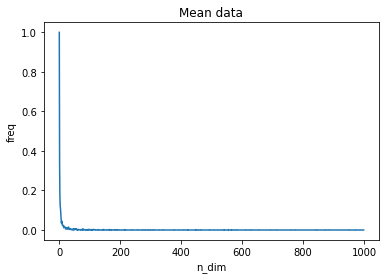

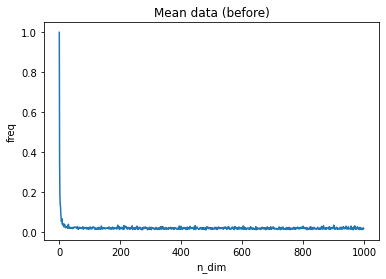

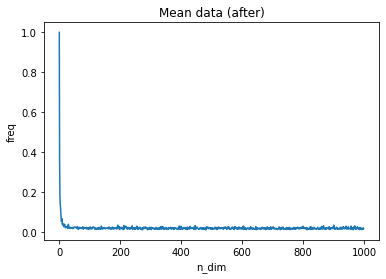

In [3]:
## Generating dataset
num_samples = 1000
n_dims = 1000
alpha = 1.5
beta = 0.5
ps = get_zipf_probs(n_dims, alpha, beta)
x = torch.bernoulli(ps.repeat(num_samples,1))
#x = x.unsqueeze(dim=0)
if len(x.shape) == 3:
    # If there is batch size dim (Batch_size_dim x num_samples x n_dim) = (Batch_size_dimxnum_samples) x n_dim (2 dim)
    # Convert tensor of three dimencions to two
    x = x.view(x.shape[0]*x.shape[1],x.shape[2])

plt.plot(torch.mean(x, dim=0).cpu().detach().numpy())
plt.title("Mean data")
plt.xlabel("n_dim")
plt.ylabel("freq")
plt.show()

## Creating count-min sketch
w = 20
d = 5
runs = 10
x_hat_before = np.zeros([runs,n_dims])
x_hat_after = np.zeros([runs,n_dims])

# Execute several times the algorithm (Changing W)
for run in range(runs):
    countmin = SketchQueryalgorithms(n_dims, w, d,'CM')


    ## Computing the mean of samples BEFORE projection
    countmin.mean_mode = 'before'
    x_hat, s = countmin.SketchQuery_algorithms(x) 
    x_mean = torch.mean(x, dim=0)
    error = torch.mean(torch.square(x_hat-x_mean))
    x_hat_before[run,:] = x_hat.cpu().detach().numpy()
    #print(f'MSE is {error}')


    ## Computing the mean of samples AFTER projection
    countmin.mean_mode = 'after'
    x_hat, s = countmin.SketchQuery_algorithms(x)
    x_mean = torch.mean(x, dim=0)
    error = torch.mean(torch.square(x_hat-x_mean))
    x_hat_after[run,:] = x_hat.cpu().detach().numpy()
    #print(f'MSE is {error}')

# Compute the mean of the differents runs
mean = np.nanmean(x_hat_before, axis=0)
plt.plot(mean)
plt.title("Mean data (before)")
plt.xlabel("n_dim")
plt.ylabel("freq")
plt.show()
plt.close()

# Compute the mean of the differents runs
mean = np.nanmean(x_hat_after, axis=0)
plt.plot(mean)
plt.title("Mean data (after)")
plt.xlabel("n_dim")
plt.ylabel("freq")
plt.show()
plt.close()
    

### Genetics Dataset

In [4]:
def plot_mean_features(data): 
    mean_features = torch.mean(data, dim=0)
    mean_features_sort = torch.sort(mean_features,descending=True)
    idx = mean_features_sort.indices
    if len(data.shape) > 1:
        shape = data.shape[1]
    else:
        shape = data.shape[0]
    x_axis = torch.arange(0, shape)
    plt.figure
    plt.plot(x_axis,mean_features_sort.values.cpu().detach().numpy())
    plt.title('Mean features', fontsize = 12)
    plt.show()
    #name_file = hparams['save_name'] + '/Loss_real.png'
    #plt.savefig(name_file) # ,dpi=300
    plt.close()  
    return idx

## Ordering the data after computing the count min sketch

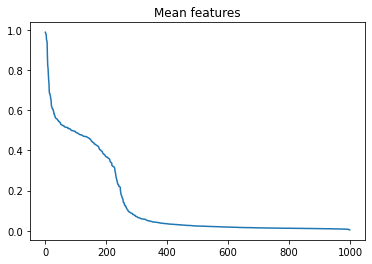

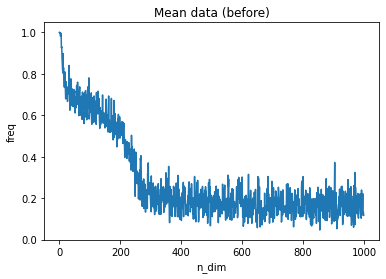

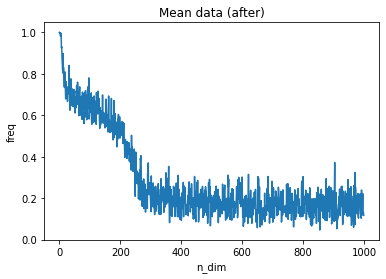

In [5]:
# Read founders
x = torch.from_numpy(data_humans['train']).float()
if len(x.shape) == 3:
    # Convert tensor of three dimencions to two
    x = x.view(x.shape[0]*x.shape[1],x.shape[2])
idx = plot_mean_features(x)

## Creating count-min sketch
n_dims = 1000
w = 200
d = 5
runs = 10
countmin = SketchQueryalgorithms(n_dims, w, d,'CM')

x_hat_before = np.zeros([runs,n_dims])
x_hat_after = np.zeros([runs,n_dims])

for run in range(runs):
    countmin = SketchQueryalgorithms(n_dims, w, d,'CM')

    ## Computing the mean of samples BEFORE projection
    countmin.mean_mode = 'before'
    x_hat, s = countmin.SketchQuery_algorithms(x)
    x_mean = torch.mean(x, dim=0)
    error = torch.mean(torch.square(x_hat-x_mean))
    x_hat_before[run,:] = x_hat.cpu().detach().numpy()
    #print(f'MSE is {error}')


    ## Computing the mean of samples AFTER projection
    countmin.mean_mode = 'after'
    x_hat, s = countmin.SketchQuery_algorithms(x)
    x_mean = torch.mean(x, dim=0)
    error = torch.mean(torch.square(x_hat-x_mean))
    sort_features_1 = []
    x_hat_after[run,:] = x_hat.cpu().detach().numpy()
    #print(f'MSE is {error}')

# Compute the mean of the differents runs
mean = np.nanmean(x_hat_before, axis=0)
order_features = mean[idx]
plt.plot(order_features)
plt.title("Mean data (before)")
plt.xlabel("n_dim")
plt.ylabel("freq")
plt.show()
plt.close()

# Compute the mean of the differents runs
mean = np.nanmean(x_hat_after, axis=0)
order_features = mean[idx]
plt.plot(order_features)
plt.title("Mean data (after)")
plt.xlabel("n_dim")
plt.ylabel("freq")
plt.show()
plt.close()
    


## Ordering the data before computing the count min sketch

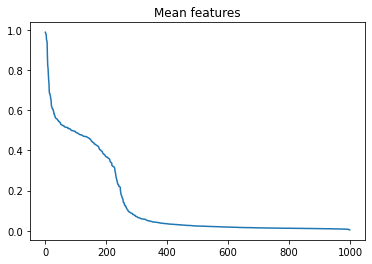

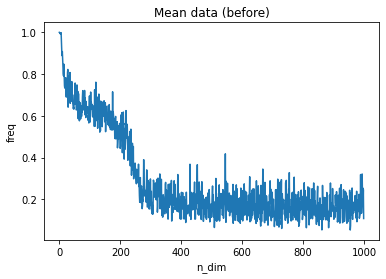

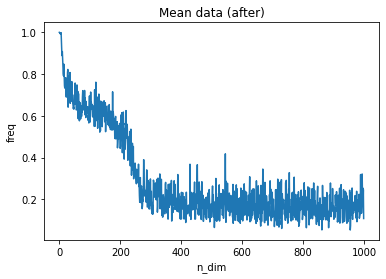

In [6]:
# Read founders
x = torch.from_numpy(data_humans['train']).float()
if len(x.shape) == 3:
    # If there is batch size dim (Batch_size_dim x num_samples x n_dim) = (Batch_size_dimxnum_samples) x n_dim (2 dim)
    # Convert tensor of three dimencions to two
    x = x.view(x.shape[0]*x.shape[1],x.shape[2])
idx = plot_mean_features(x)

## Creating count-min sketch
n_dims = 1000
w = 200
d = 5
runs = 10

x_hat_before = np.zeros([runs,n_dims])
x_hat_after = np.zeros([runs,n_dims])

for run in range(runs):
    countmin = SketchQueryalgorithms(n_dims, w, d,'CM')
    order_features = x[:,idx]

    ## Computing the mean of samples BEFORE projection
    countmin.mean_mode = 'before'
    x_hat, s = countmin.SketchQuery_algorithms(order_features)
    x_mean = torch.mean(order_features, dim=0)
    error = torch.mean(torch.square(x_hat-x_mean))
    x_hat_before[run,:] = x_hat.cpu().detach().numpy()
    #print(f'MSE is {error}')


    ## Computing the mean of samples AFTER projection
    countmin.mean_mode = 'after'
    x_hat, s = countmin.SketchQuery_algorithms(order_features)
    x_mean = torch.mean(order_features, dim=0)
    error = torch.mean(torch.square(x_hat-x_mean))
    x_hat_after[run,:] = x_hat.cpu().detach().numpy()
    #print(f'MSE is {error}')

# Compute the mean of the differents runs
mean = np.nanmean(x_hat_before, axis=0)
plt.plot(mean)
plt.title("Mean data (before)")
plt.xlabel("n_dim")
plt.ylabel("freq")
plt.show()
plt.close()

# Compute the mean of the differents runs
mean = np.nanmean(x_hat_after, axis=0)
plt.plot(mean)
plt.title("Mean data (after)")
plt.xlabel("n_dim")
plt.ylabel("freq")
plt.show()
plt.close()
    


### MNIST Dataset

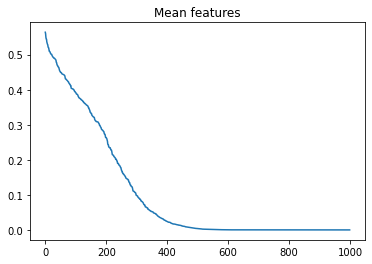

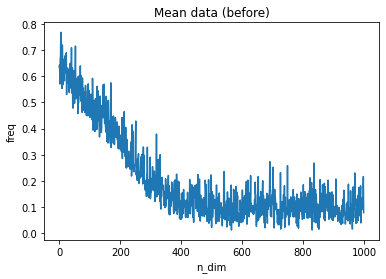

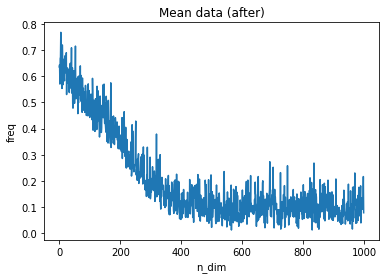

In [7]:
# Read founders
x = torch.from_numpy(data_MNIST['train']).float()
idx = plot_mean_features(x)
    
## Creating count-min sketch
n_dims = 1000
w = 200
d = 5
runs = 10

x_hat_before = np.zeros([runs,n_dims])
x_hat_after = np.zeros([runs,n_dims])

for run in range(runs):
    countmin = SketchQueryalgorithms(n_dims, w, d,'CM')
    order_features = x[:,idx]

    ## Computing the mean of samples BEFORE projection
    countmin.mean_mode = 'before'
    x_hat, s = countmin.SketchQuery_algorithms(order_features)
    x_mean = torch.mean(order_features, dim=0)
    error = torch.mean(torch.square(x_hat-x_mean))
    x_hat_before[run,:] = x_hat.cpu().detach().numpy()
    #print(f'MSE is {error}')


    ## Computing the mean of samples AFTER projection
    countmin.mean_mode = 'after'
    x_hat, s = countmin.SketchQuery_algorithms(order_features)
    x_mean = torch.mean(order_features, dim=0)
    error = torch.mean(torch.square(x_hat-x_mean))
    x_hat_after[run,:] = x_hat.cpu().detach().numpy()
    #print(f'MSE is {error}')

# Compute the mean of the differents runs
mean = np.nanmean(x_hat_before, axis=0)
plt.plot(mean)
plt.title("Mean data (before)")
plt.xlabel("n_dim")
plt.ylabel("freq")
plt.show()
plt.close()

# Compute the mean of the differents runs
mean = np.nanmean(x_hat_after, axis=0)
plt.plot(mean)
plt.title("Mean data (after)")
plt.xlabel("n_dim")
plt.ylabel("freq")
plt.show()
plt.close()

## Count-Min (CM) vs Count-Sketch (CS) with a particular d and w

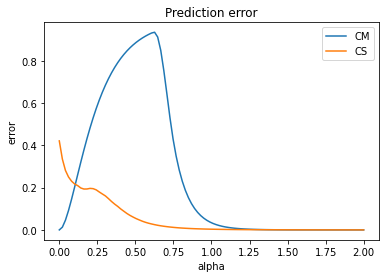

In [8]:
## Creating sketches
n_dims = 1000
w = 20
d = 5
countmin = SketchQueryalgorithms(n_dims, w, d,'CM')
countsketch = SketchQueryalgorithms(n_dims, w, d,'CS')

## Benchmarking
errors_cs = []
errors_cm = []

beta = 1.0
space = torch.linspace(0, 2.0, 100)
for alpha in list(space):
    x = get_zipf_probs(n_dims, alpha, beta)
    
    x_hat, s = countsketch.SketchQuery_algorithms(x)
    error = torch.mean(torch.square(torch.clamp(x_hat, 0, 1)-x))
    errors_cs.append(error)
    
    x_hat, s = countmin.SketchQuery_algorithms(x)
    error = torch.mean(torch.square(torch.clamp(x_hat, 0, 1)-x))
    errors_cm.append(error)

errors_cm = torch.stack(errors_cm) 
errors_cs = torch.stack(errors_cs)    

plt.plot(space.cpu().detach().numpy(), errors_cm.cpu().detach().numpy())
plt.plot(space.cpu().detach().numpy(), errors_cs.cpu().detach().numpy())
plt.title("Prediction error")
plt.xlabel("alpha")
plt.ylabel("error")
plt.legend(['CM', 'CS'])
plt.show()

## Count-Min (CM) vs Count-Sketch (CS) with the optimal d and w

#### Sketch size 100 (num samples 10)

In [9]:
# Read df_cm and df_cs
# Num samples 1000
df_cm = pd.read_csv('../../results/benchmark_wd/optimum_w_d_CM_sketch_100.csv') 
df_cs = pd.read_csv('../../results/benchmark_wd/optimum_w_d_CS_sketch_100.csv') 

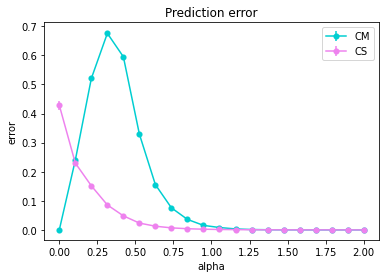

In [10]:
Beta = 1.0
# Count Min Sketch
dif_alphas_CM = df_cm[df_cm['beta']==Beta]
#plt.plot(dif_alphas_CM['alpha'],dif_alphas_CM['Mean_MSE'],label='CM')
plt.errorbar(dif_alphas_CM['alpha'],dif_alphas_CM['MSE'], yerr = dif_alphas_CM['sd_MSE'], fmt = '-o', 
            color = 'darkturquoise',markeredgewidth=0.1,label='CM')
# Count Sketch
dif_alphas_CS = df_cs[df_cs['beta']==Beta]
#plt.plot(dif_alphas_CS['alpha'],dif_alphas_CS['Mean_MSE'],label='CS')
plt.errorbar(dif_alphas_CS['alpha'],dif_alphas_CS['MSE'], yerr = dif_alphas_CS['sd_MSE'], fmt = '-o', 
            color = 'violet',markeredgewidth=0.1,label='CS')
plt.title("Prediction error")
plt.xlabel("alpha")
plt.ylabel("error")
plt.legend()
plt.show()
plt.close()